# Imports & Configuration

In [1]:
!pip install roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=a7375c5516fd134353621e15e7ca51ac12c98c42cb4c98ce8d5ce7b7e0c2da27
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

In [2]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.2/562.2 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 26.9 MB/s eta 0:00:00


In [3]:
import os
import cv2
import yaml
from PIL import Image
from ultralytics import YOLO
from roboflow import Roboflow
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

In [4]:
%rm -rf sample_data

# Download the input data

In [5]:
rf = Roboflow(api_key="rhmGQBsVSvmY2pOM6sEB")
project = rf.workspace("roboflow-universe-projects").project("construction-site-safety")
dataset = project.version(30).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.90, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to Construction-Site-Safety-30 in yolov8:: 100%|██████████| 1446/1446 [00:00<00:00, 1980.70it/s]


In [6]:
%ls //content/Construction-Site-Safety-30

data.yaml  README.dataset.txt  README.roboflow.txt  test/  train/  valid/


In [7]:
print("Всего изображений:")
print("\tTrain: %s" % len(os.listdir("//content/Construction-Site-Safety-30/train/images")))
print("\tValid: %s" % len(os.listdir("//content/Construction-Site-Safety-30/valid/images")))
print("\t Test: %s" % len(os.listdir("//content/Construction-Site-Safety-30/test/images")))

Всего изображений:
	Train: 521
	Valid: 114
	 Test: 82


Корректируем `data.yaml`

In [8]:
config = \
"""names:
- Excavator
- Gloves
- Hardhat
- Ladder
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- SUV
- Safety Cone
- Safety Vest
- bus
- dump truck
- fire hydrant
- machinery
- mini-van
- sedan
- semi
- trailer
- truck and trailer
- truck
- van
- vehicle
- wheel loader
nc: 25
roboflow:
  license: CC BY 4.0
  project: construction-site-safety
  url: https://universe.roboflow.com/roboflow-universe-projects/construction-site-safety/dataset/30
  version: 30
  workspace: roboflow-universe-projects
path: //content/Construction-Site-Safety-30
test: ../test/images
train: ../train/images
val: ../valid/images"""

with open("//content/Construction-Site-Safety-30/data.yaml", "w") as f:
  f.write(config)

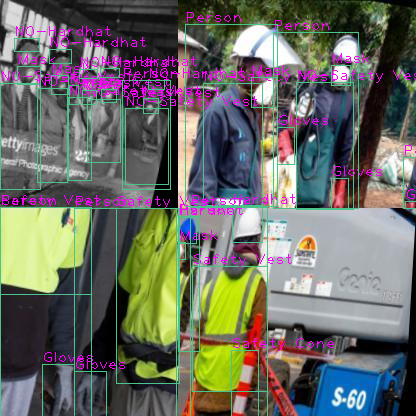

In [9]:
def convert_digit(s: str):
  if s.isdecimal():
    return int(s)
  return float(s)


root = "//content/Construction-Site-Safety-30/train"
idx = 50

# get class names
with open("//content/Construction-Site-Safety-30/data.yaml", 'r') as stream:
  metadata = yaml.safe_load(stream)
cl_names = metadata["names"]

# open an image
img_name = os.listdir(os.path.join(root, "images"))[idx]
img_path = os.path.join(root, "images", img_name)
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

# read labels
label_path = os.path.join(root, "labels", os.path.splitext(img_name)[0] + ".txt")

# plot
img_h, img_w, _ = img.shape
with open(label_path, 'r') as f:
  for obj in f:
    cl, x, y, w, h = map(convert_digit, obj.strip().split())  # class, xc, yc, w, h
    x = round((x - w/2)*img_w)  # convert to x left 
    y = round((y - h/2)*img_h)  # convert to y bottom
    w = round(w*img_w)
    h = round(h*img_h)
    cv2.rectangle(img, (x, y), (x + w, y + h), (139, 195, 75), 1)
    cv2.putText(img=img, text=cl_names[cl], org=(max(0, x), max(5, y - 2)), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1, color=(255, 0, 255), thickness=1)
cv2_imshow(img)

# Train model

Информация по видеокарте

In [10]:
!nvidia-smi

Sun Apr 30 08:07:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Запускаем процесс обучения

In [11]:
!yolo task=detect mode=train model=yolov8l.pt data=//content/Construction-Site-Safety-30/data.yaml epochs=50 imgsz=640

100% 83.7M/83.7M [00:04<00:00, 21.4MB/s]
Ultralytics YOLOv8.0.90 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=//content/Construction-Site-Safety-30/data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, op

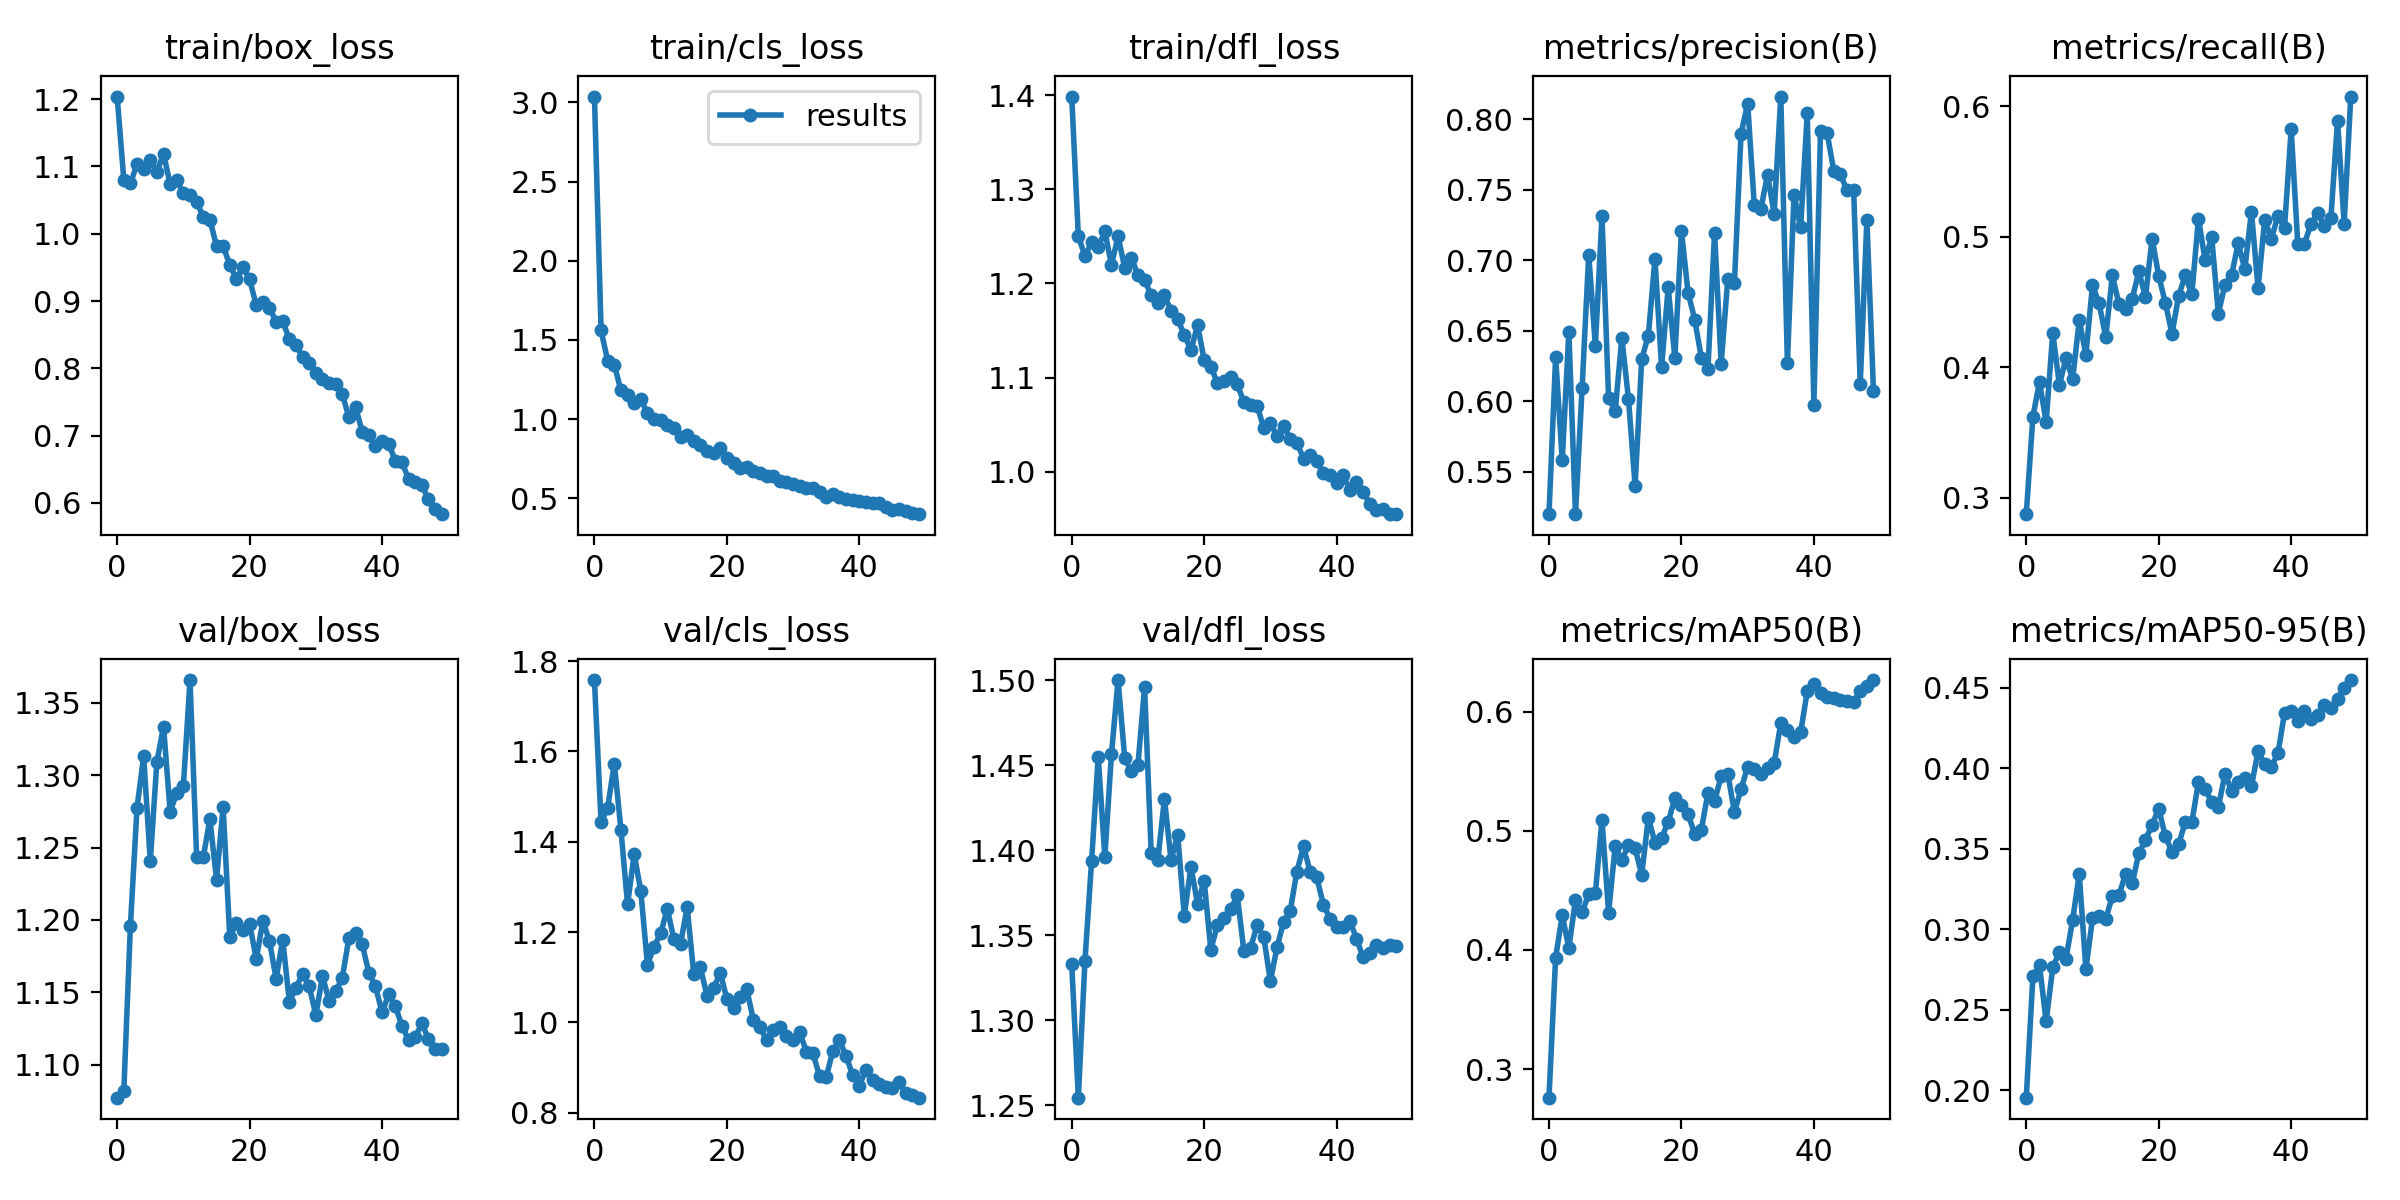

In [14]:
results = cv2.imread("//content/runs/detect/train/results.png", cv2.IMREAD_UNCHANGED)
cv2_imshow(results)

Процесс обучения не завершен, но у нас нет цели добиться потрясающих результатов, поэтому остановимся на том, что есть (50 эпох).

Загрузим результаты из Colab.

In [16]:
!tar -cvf results.tar //content/runs

tar: Removing leading `//' from member names
//content/runs/
//content/runs/detect/
//content/runs/detect/train/
//content/runs/detect/train/weights/
//content/runs/detect/train/weights/last.pt
//content/runs/detect/train/weights/best.pt
//content/runs/detect/train/args.yaml
//content/runs/detect/train/train_batch0.jpg
//content/runs/detect/train/train_batch1.jpg
//content/runs/detect/train/PR_curve.png
//content/runs/detect/train/labels.jpg
//content/runs/detect/train/val_batch2_labels.jpg
//content/runs/detect/train/P_curve.png
//content/runs/detect/train/confusion_matrix.png
//content/runs/detect/train/R_curve.png
//content/runs/detect/train/results.csv
//content/runs/detect/train/labels_correlogram.jpg
//content/runs/detect/train/val_batch0_pred.jpg
//content/runs/detect/train/F1_curve.png
//content/runs/detect/train/results.png
//content/runs/detect/train/val_batch2_pred.jpg
//content/runs/detect/train/val_batch1_labels.jpg
//content/runs/detect/train/val_batch0_labels.jpg
//conte